In [1]:
import gdown
import os
import pandas as pd
import numpy as np

# from google.colab import files
# uploaded = files.upload()

# sp500_df = pd.read_csv('sp500_dataframe.csv')
# sp500_df.head()

# file share for the companies Dataset: https://drive.google.com/file/d/154LPFNKqEr4Pgz1nwDaCG_b9ZK4P2yVH/view?usp=sharing

file_id_comp = "154LPFNKqEr4Pgz1nwDaCG_b9ZK4P2yVH"
output_file_comp = "sp500_companies.csv"

if not os.path.exists(output_file_comp):
    gdown.download(f"https://drive.google.com/uc?id={file_id_comp}&confirm=t", output_file_comp, quiet=False)

sp500 = pd.read_csv(output_file_comp)
sp500.head()

# file share for the processed Dataset: https://drive.google.com/file/d/1TFyUlcB8PbMokVsdB0ZtYzadYnhUJWNN/view?usp=sharing

file_id_df = "1TFyUlcB8PbMokVsdB0ZtYzadYnhUJWNN"
output_file_df = "sp500_dataframe.csv"

if not os.path.exists(output_file_df):
    gdown.download(f"https://drive.google.com/uc?id={file_id_df}&confirm=t", output_file_df, quiet=False)

sp500_df = pd.read_csv(output_file_df)
sp500_df.head()

sp500_tickers = sp500['Symbol'].tolist()
sp500_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Remove numeric index and repalce with the date

sp500_df.set_index("Date", inplace=True)
sp500_df.index.name = None

# Remove tickers row
sp500_df = sp500_df.drop(sp500_df.index[0])
# Remove the date row
sp500_df = sp500_df.drop(sp500_df.index[1])
# Remove the price row
sp500_df = sp500_df.drop(sp500_df.index[2])
sp500_df = sp500_df.drop(sp500_df.index[0])

data = sp500_df.iloc[:, 1:].to_numpy()
n_things = data.shape[1] // 9

reshapedd = data.reshape(data.shape[0], n_things, 9)

final_array = reshapedd.transpose(1, 0, 2)
final_array = np.array(final_array, dtype=np.float64)

final_array = final_array[~np.isnan(final_array).any(axis=(1, 2))]
final_array.shape

<ipython-input-1-6738dfb4bad0>:31: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,26

(423, 514, 9)

In [2]:
import math
from sklearn.metrics import mean_squared_error

# helper function, basically seperates everything for us
def create_dataset(dataset, time_step):
  dx, dy = [], []
  for i in range(len(dataset)-time_step-1):
      a = dataset[i:(i+time_step), 0]
      dx.append(a)
      dy.append(dataset[i + time_step, 0])
  return np.array(dx), np.array(dy)

# returns a trained model
def trainedModel(dataset, scale, model):
  time_step = 50

  for i in dataset:

    # split data by 70%
    split_size = int(len(i) * 0.70)
    training_set = i[0:split_size, :]
    testing_set = i[split_size: , :1]

    # how much data do we need from the past to get the future (next week)
    X_train, y_train = create_dataset(training_set, time_step)
    X_test, ytest = create_dataset(testing_set, time_step)

    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

    # train model
    model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=30,batch_size=64,verbose=1)


    # how well ?

    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    train_predict = scaler.inverse_transform(train_predict)
    test_predict = scaler.inverse_transform(test_predict)

    print(math.sqrt(mean_squared_error(y_train,train_predict)))
    print(math.sqrt(mean_squared_error(ytest,test_predict)))



In [3]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU

# preprocessing
time_step = 50
scaler = MinMaxScaler(feature_range=(0, 1))
og_shape = final_array[:20, :, :1].shape
scaled_data = scaler.fit_transform(final_array[:20, :, :1].reshape(-1, 1))
scaled_data = scaled_data.reshape(og_shape)
print(scaled_data.shape)

model=Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

trainedModel(scaled_data, scaler, model)

(20, 514, 1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 276ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0017 - val_loss: 0.0086
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0010 - val_loss: 0.0049
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 5.2928e-04 - val_loss: 2.3562e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.0933e-04 - val_loss: 2.5845e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.6895e-04 - val_loss: 0.0020
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.0895e-04 - val_loss: 2.3384e-04
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 9.4393e-05 - val_loss: 2.2218e-04
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 8.2631e-05 - val_loss: 2.1900e-04
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7.1473e-05 - val_loss: 3.3313e-04
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.1714e-05 - val_loss: 4.5257e-04
Epoch 12/30
5/5 ━━━━━━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(514, 1)
(514, 1)


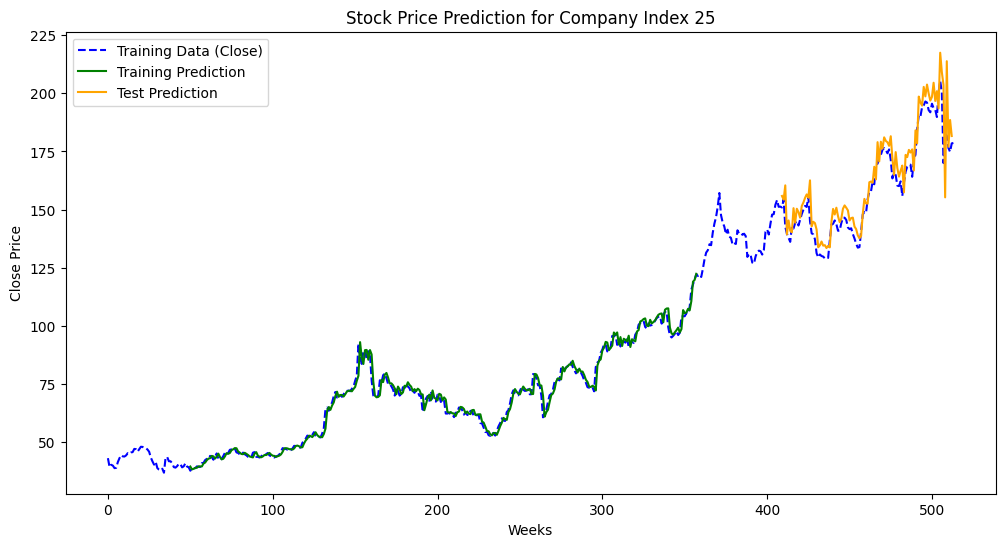

In [17]:
import matplotlib.pyplot as plt


look_back = time_step

df1 = scaler.fit_transform(final_array[25, :, :1].reshape(-1, 1))
split_size = int(len(df1) * 0.70)
training_set = df1[0:split_size, :]
testing_set = df1[split_size: , :1]

# how much data do we need from the past to get the future (next week)
X_train, y_train = create_dataset(training_set, look_back)
X_test, ytest = create_dataset(testing_set, look_back)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
print(testPredictPlot.shape)

# plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.title(f"Stock Price Prediction for Company Index 25")
plt.xlabel("Weeks")
plt.ylabel("Close Price")
plt.plot(scaler.inverse_transform(df1), label="Training Data (Close)",  linestyle="--", color="blue")
plt.plot(trainPredictPlot, label="Training Prediction", color="green")
plt.plot(testPredictPlot, label="Test Prediction", color="orange")
plt.legend()
plt.show()

In [11]:
model_gru = Sequential()
model_gru.add(GRU(50, return_sequences=True, input_shape=(time_step, 1)))
model_gru.add(GRU(50, return_sequences=True))
model_gru.add(GRU(50))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

trainedModel(scaled_data, scaler, model_gru)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 2/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 8.1579e-04 - val_loss: 0.0072
Epoch 3/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 7.1932e-04 - val_loss: 3.9568e-04
Epoch 4/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.7883e-04 - val_loss: 5.5860e-04
Epoch 5/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1.5451e-04 - val_loss: 1.9808e-04
Epoch 6/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7.7906e-05 - val_loss: 2.6618e-04
Epoch 7/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 7.0026e-05 - val_loss: 1.8966e-04
Epoch 8/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 4.4703e-05 - val_loss: 9.7731e-05
Epoch 9/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 3.2485e-05 - val_loss: 1.0546e-04
Epoch 10/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 3.2326e-05 - val_loss: 9.0233e-05
Epoch 11/30
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 2.8234e-05 - val_loss: 9.0341e-05
Epoch 12/30
5/5 ━━━

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
(514, 1)
(514, 1)


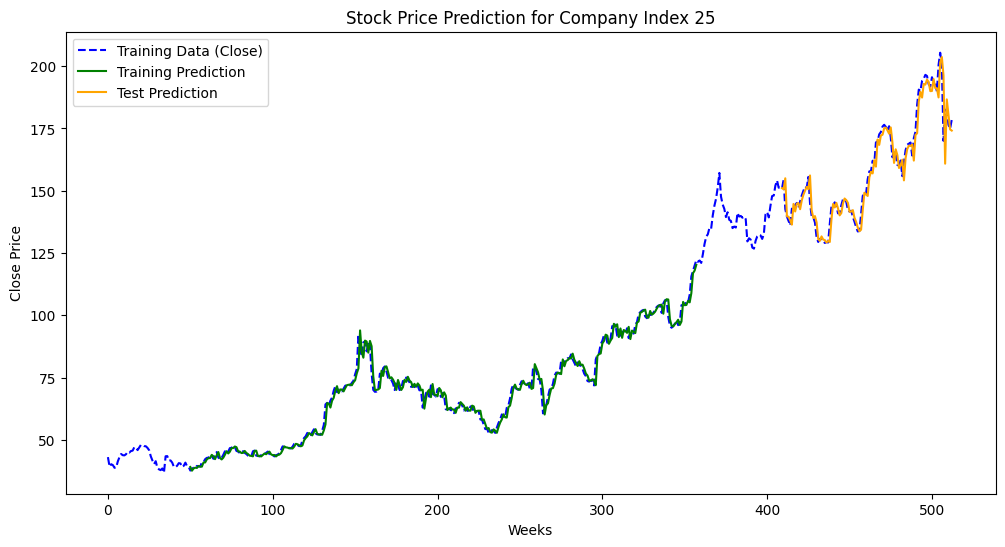

In [16]:
import matplotlib.pyplot as plt


look_back = time_step

df1 = scaler.fit_transform(final_array[25, :, :1].reshape(-1, 1))
split_size = int(len(df1) * 0.70)
training_set = df1[0:split_size, :]
testing_set = df1[split_size: , :1]

# how much data do we need from the past to get the future (next week)
X_train, y_train = create_dataset(training_set, look_back)
X_test, ytest = create_dataset(testing_set, look_back)
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
train_predict = model_gru.predict(X_train)
test_predict = model_gru.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print(trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
print(testPredictPlot.shape)

# plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.title(f"Stock Price Prediction for Company Index 25")
plt.xlabel("Weeks")
plt.ylabel("Close Price")
plt.plot(scaler.inverse_transform(df1), label="Training Data (Close)",  linestyle="--", color="blue")
plt.plot(trainPredictPlot, label="Training Prediction", color="green")
plt.plot(testPredictPlot, label="Test Prediction", color="orange")
plt.legend()
plt.show()